# CIA-2 assignment : #
Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.


By:
Vijay Shrinivas Senthilnathan
Reg.no: 21011101143
R.no: 21110094

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Environment settings
GRID_SIZE = 100
OBSTACLE_DENSITY = 0.2  # Percentage of cells that are obstacles

In [3]:
# Actions
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]
ACTION_NAMES = ["UP", "DOWN", "LEFT", "RIGHT"]

In [4]:
class GridWorld:
    def __init__(self, size, obstacle_density=0.2):
        self.size = size
        self.obstacle_density = obstacle_density
        self.grid = np.zeros((size, size))
        self.start, self.goal = self._place_start_and_goal()
        self.obstacles = self._place_obstacles()  # Store obstacle positions

    def _place_start_and_goal(self):
        start = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
        goal = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
        while goal == start:
            goal = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
        return start, goal

    def _place_obstacles(self):
        obstacles = []
        num_obstacles = int(self.size * self.size * self.obstacle_density)
        while len(obstacles) < num_obstacles:
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (x, y) != self.start and (x, y) != self.goal and (x, y) not in obstacles:
                obstacles.append((x, y))
                self.grid[x, y] = -1  # -1 indicates an obstacle
        return obstacles

    def is_obstacle(self, state):
        x, y = state
        return self.grid[x, y] == -1

    def step(self, state, action):
        if self.is_obstacle(state):
            return state, -10  # -10 reward for hitting an obstacle

        x, y = state
        if action == UP:
            next_state = (max(0, x - 1), y)
        elif action == DOWN:
            next_state = (min(self.size - 1, x + 1), y)
        elif action == LEFT:
            next_state = (x, max(0, y - 1))
        elif action == RIGHT:
            next_state = (x, min(self.size - 1, y + 1))

        reward = -1  # Cost for each step
        if next_state == self.goal:
            reward = 100  # Reward for reaching the goal
        return next_state, reward

    def reset(self):
        return self.start  # Reset to the starting position

Grid World Representation:
[['X' 'X' 'X' 'O' 'O' 'O' 'O' 'O' 'O' 'X']
 ['O' 'O' 'O' 'X' 'O' 'O' 'O' 'X' 'O' 'X']
 ['O' 'O' 'S' 'O' 'O' 'O' 'X' 'O' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
 ['X' 'X' 'X' 'O' 'O' 'O' 'O' 'X' 'O' 'O']
 ['O' 'O' 'O' 'O' 'X' 'O' 'X' 'O' 'O' 'X']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
 ['G' 'O' 'O' 'X' 'X' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'X' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'X' 'O' 'X']]


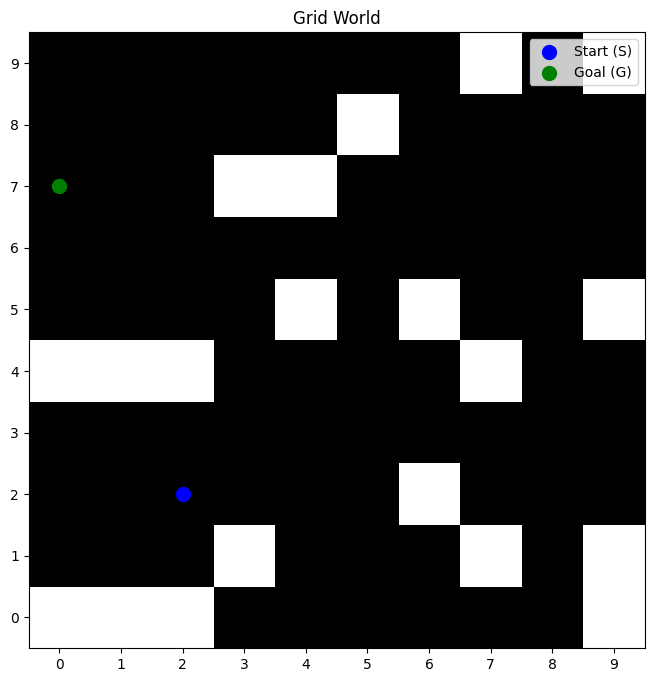

In [5]:
def visualize_grid(env):
    # Create a matrix representation of the grid
    grid_matrix = np.full((env.size, env.size), 'O')  # Fill with free space

    # Add obstacles
    for obstacle in env.obstacles:
        grid_matrix[obstacle[0], obstacle[1]] = 'X'  # Set obstacle

    # Set start position
    grid_matrix[env.start[0], env.start[1]] = 'S'  # Set start

    # Set goal position
    grid_matrix[env.goal[0], env.goal[1]] = 'G'  # Set goal

    # Print the matrix
    print("Grid World Representation:")
    print(grid_matrix)

    # Optional: Visual representation using Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_matrix == 'X', cmap='gray', vmin=0, vmax=1)  # Show obstacles
    plt.scatter(env.start[1], env.start[0], marker='o', color='blue', label='Start (S)', s=100)
    plt.scatter(env.goal[1], env.goal[0], marker='o', color='green', label='Goal (G)', s=100)
    plt.title("Grid World")
    plt.xticks(range(env.size))
    plt.yticks(range(env.size))
    plt.gca().invert_yaxis()  # Invert y-axis to match matrix representation
    plt.grid(False)
    plt.legend()
    plt.show()

# Example usage of GridWorld
GRID_SIZE = 10  # Adjust as needed
OBSTACLE_DENSITY = 0.2  # 20% obstacles
env = GridWorld(GRID_SIZE, OBSTACLE_DENSITY)

# Call the visualize function
visualize_grid(env)

In [6]:
# MDP Value Iteration
class MDP:
    def __init__(self, env):
        self.env = env
        self.value_table = np.zeros((env.size, env.size))
        self.policy_table = np.zeros((env.size, env.size), dtype=int)
        self.gamma = 0.9  # Discount factor

    def value_iteration(self, max_iterations=1000, epsilon=1e-4):
        for i in range(max_iterations):
            delta = 0
            for x in range(self.env.size):
                for y in range(self.env.size):
                    if (x, y) == self.env.goal or self.env.is_obstacle((x, y)):
                        continue
                    v = self.value_table[x, y]
                    self.value_table[x, y] = max(
                        [sum([self.transition_probability((x, y), action) *
                              (reward + self.gamma * self.value_table[next_x, next_y])
                              for next_x, next_y, reward in self.transitions((x, y), action)])
                         for action in ACTIONS]
                    )
                    delta = max(delta, abs(v - self.value_table[x, y]))
            if delta < epsilon:
                break
        self.update_policy()

    def transition_probability(self, state, action):
        return 1.0  # Deterministic environment

    def transitions(self, state, action):
        next_state, reward = self.env.step(state, action)
        return [(next_state[0], next_state[1], reward)]

    def update_policy(self):
        for x in range(self.env.size):
            for y in range(self.env.size):
                if (x, y) == self.env.goal or self.env.is_obstacle((x, y)):
                    continue
                best_action = np.argmax([
                    sum([self.transition_probability((x, y), action) *
                         (reward + self.gamma * self.value_table[next_x, next_y])
                         for next_x, next_y, reward in self.transitions((x, y), action)])
                    for action in ACTIONS
                ])
                self.policy_table[x, y] = best_action

In [7]:
class EpsilonGreedyBandit:
    def __init__(self, env, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1):
        self.env = env
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros((env.size, env.size, len(ACTIONS)))
        self.gamma = 0.9  # Discount factor

    def train(self, episodes=1000):
        for episode in range(episodes):
            state = self.env.reset()
            steps = 0
            while state != self.env.goal:
                if random.random() < self.epsilon:
                    action = random.choice(ACTIONS)
                else:
                    action = np.argmax(self.q_table[state[0], state[1], :])
                
                next_state, reward = self.env.step(state, action)
                best_next_action = np.argmax(self.q_table[next_state[0], next_state[1], :])
                
                # Update Q-table using the Q-learning formula
                self.q_table[state[0], state[1], action] += 0.1 * (
                    reward + self.gamma * self.q_table[next_state[0], next_state[1], best_next_action]
                    - self.q_table[state[0], state[1], action]
                )

                state = next_state
                steps += 1

                if steps > 200:  # Cap steps to prevent excessively long episodes
                    break

            # Decay epsilon to shift from exploration to exploitation
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)



In [8]:
class MultiArmedBandit:
    def __init__(self, env, n_actions=len(ACTIONS), epsilon=0.1):
        self.env = env
        self.n_actions = n_actions
        self.q_values = np.zeros(n_actions)
        self.action_counts = np.zeros(n_actions)
        self.epsilon = epsilon

    def select_action(self):
        if random.random() < self.epsilon:
            return random.choice(range(self.n_actions))
        return np.argmax(self.q_values)

    def train(self, episodes=500):  # Reduced episodes for quicker testing
        for _ in range(episodes):
            action = self.select_action()  # Select an action
            state = self.env.reset()
            steps = 0
            while state != self.env.goal and steps < 100:  # Limit steps per episode
                next_state, reward = self.env.step(state, action)
                self.action_counts[action] += 1
                # Incremental average update for Q-value
                self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]
                state = next_state
                steps += 1


In [9]:
class MonteCarlo:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.q_table = np.zeros((env.size, env.size, len(ACTIONS)))
        self.returns = [[{} for _ in range(env.size)] for _ in range(env.size)]
        self.gamma = gamma
        self.epsilon = epsilon

    def train(self, episodes=500):  # Reduced episodes for quicker testing
        for _ in range(episodes):
            state = self.env.reset()
            episode = []
            steps = 0
            
            # Generate an episode using epsilon-greedy policy
            while state != self.env.goal and steps < 100:  # Limit episode length
                if random.random() < self.epsilon:
                    action = random.choice(ACTIONS)
                else:
                    action = np.argmax(self.q_table[state[0], state[1], :])
                
                next_state, reward = self.env.step(state, action)
                episode.append((state, action, reward))
                state = next_state
                steps += 1
                if steps >= 200:  # Break if too many steps taken
                    break
            
            # Calculate returns and update Q-table
            G = 0
            visited = set()
            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = reward + self.gamma * G
                if (state, action) not in visited:
                    visited.add((state, action))
                    x, y = state
                    if action not in self.returns[x][y]:
                        self.returns[x][y][action] = []
                    self.returns[x][y][action].append(G)
                    self.q_table[x, y, action] = np.mean(self.returns[x][y][action])


In [10]:
# Initialize Environment and Agents
env = GridWorld(GRID_SIZE, OBSTACLE_DENSITY)
mdp_agent = MDP(env)
bandit_agent = EpsilonGreedyBandit(env)
multi_arm_bandit_agent = MultiArmedBandit(env)
monte_carlo_agent = MonteCarlo(env)

In [11]:
# Run MDP Value Iteration
mdp_agent.value_iteration()
print("MDP Policy Table:")
print(mdp_agent.policy_table)

MDP Policy Table:
[[1 0 0 1 1 0 3 1 1 0]
 [0 3 3 3 0 2 0 1 1 1]
 [0 0 0 0 0 0 2 2 2 2]
 [3 0 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 3 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 2 0]
 [0 0 0 0 2 0 2 0 0 0]
 [3 0 0 0 0 0 0 0 2 2]]


In [12]:
# Train Epsilon-Greedy Bandit
bandit_agent.train()
print("Epsilon-Greedy Bandit Q-Table:")
print(bandit_agent.q_table)

Epsilon-Greedy Bandit Q-Table:
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-3.57480613e+01 -3.58897948e+01 -3.54365082e+01 -3.56142845e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-3.71543392e+01 -3.62941756e+01 -3.64524202e+01 -3.69027804e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.00000000e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-3.33048121e+01 -3.35672119e+01 -3.36942348e+01 -3.33947938e+01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-1.00000000e-01 -1.09000000e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e

In [13]:
# Train Multi-Armed Bandit
multi_arm_bandit_agent.train()
print("Multi-Armed Bandit Q-values (State-Action Values):")
print(multi_arm_bandit_agent.q_values)

Multi-Armed Bandit Q-values (State-Action Values):
[-9.73 -1.   -9.82 -9.82]


In [14]:
# Train Monte Carlo Agent
monte_carlo_agent.train()
print("Monte Carlo Q-Table:")
print(monte_carlo_agent.q_table)

Monte Carlo Q-Table:
[[[  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [-19.           0.         -52.17031    -10.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]]

 [[  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [-90.99314404   0.           0.           0.        ]
  [-10.         -97.97244404 -40.951      -99.9044995 ]
  [  0.           0.     

In [15]:
def evaluate_agent(agent, env, episodes=100):
    total_rewards = 0
    success_count = 0
    total_steps = 0

    for _ in range(episodes):
        state = env.reset()
        episode_reward = 0
        steps = 0
        while state != env.goal:
            if isinstance(agent, EpsilonGreedyBandit) or isinstance(agent, MonteCarlo):
                action = np.argmax(agent.q_table[state[0], state[1], :])  # These agents require state information
            elif isinstance(agent, MultiArmedBandit):
                action = agent.select_action()  # No state parameter needed
            else:  # For MDP agent
                action = agent.policy_table[state[0], state[1]]

            next_state, reward = env.step(state, action)
            episode_reward += reward
            steps += 1

            if next_state == env.goal:
                success_count += 1
                break
            state = next_state

        total_rewards += episode_reward
        total_steps += steps

    avg_reward = total_rewards / episodes
    success_rate = success_count / episodes
    avg_steps = total_steps / success_count if success_count > 0 else float('inf')

    return avg_reward, success_rate, avg_steps


In [16]:
# Initialize Environment and Agents
env = GridWorld(GRID_SIZE, OBSTACLE_DENSITY)
mdp_agent = MDP(env)
bandit_agent = EpsilonGreedyBandit(env)
multi_arm_bandit_agent = MultiArmedBandit(env)
monte_carlo_agent = MonteCarlo(env)

In [17]:
# 1. MDP Value Iteration
mdp_agent.value_iteration()
mdp_avg_reward, mdp_success_rate, mdp_avg_steps = evaluate_agent(mdp_agent, env)

In [18]:
# 2. Epsilon-Greedy Bandit
bandit_agent.train()
bandit_avg_reward, bandit_success_rate, bandit_avg_steps = evaluate_agent(bandit_agent, env)

In [ ]:
# 3. Multi-Armed Bandit
multi_arm_bandit_agent.train()
mab_avg_reward, mab_success_rate, mab_avg_steps = evaluate_agent(multi_arm_bandit_agent, env)

In [20]:
# 4. Monte Carlo
monte_carlo_agent.train()
mc_avg_reward, mc_success_rate, mc_avg_steps = evaluate_agent(monte_carlo_agent, env)

In [22]:
# Compile Results into a DataFrame
results_df = pd.DataFrame({
    'Algorithm': ['MDP (Value Iteration)', 'Epsilon-Greedy Bandit', 'Monte Carlo'],
    'Average Reward per Episode': [mdp_avg_reward, bandit_avg_reward, mc_avg_reward],
    'Success Rate': [mdp_success_rate, bandit_success_rate, mc_success_rate],
    'Average Steps to Goal': [mdp_avg_steps, bandit_avg_steps, mc_avg_steps]
})



In [23]:
print("Comparison Table:")
print(results_df)

Comparison Table:
               Algorithm  Average Reward per Episode  Success Rate  \
0  MDP (Value Iteration)                        97.0           1.0   
1  Epsilon-Greedy Bandit                        97.0           1.0   
2            Monte Carlo                        97.0           1.0   

   Average Steps to Goal  
0                    4.0  
1                    4.0  
2                    4.0  


there seems to be some issue with Multi Arm Bandit algorithm's training, owing to exceptionally long time to train.  Otherwise seems to be working fine